<a href="https://colab.research.google.com/github/marytaylor/Attrition-Prediction-Models/blob/master/V5_Modeling_(XGBoost%2C_KNN%2C_RF%2C_SVM%2C_LDA%2C_LogReg%2C_NN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

These models include the use of our selected features and the clustering output, as well as binned features after experimentation. SMOTE has been excluded because it did not help with model accuracy.
Data formatting has been added to this new data set for better coefficient analysis.

Additionally, all previous feature analysis and EDA has been included in this notebook as the final notebook.


# Notebook and Data Setup

In [2]:
# installing package that lets me use CSV files in google drive

# comment the line out below because it only needs to be run once
!pip install -U -q PyDrive

     |████████████████████████████████| 993kB 2.8MB/s 


In [0]:
# ==================================
# Packages 
# ==================================

# data manipulation and visualization packages
import pandas as pd
import numpy as np
import random as rn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# package for oversampling (SMOTE)
from imblearn.over_sampling import SMOTE

# modeling packages
import statsmodels.api as sm
import statsmodels.formula.api as smf
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

# model metrics and scoring
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report

# packages specific to neural network
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
import tensorflow as tf

# These are used for getting data from Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate using the four packages above and create the PyDrive client (i.e. login to get data from Google Drive)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Using the two lines below to hide a warning message about visualization
import warnings
warnings.filterwarnings("ignore")

# Make sure pandas prints all columns
pd.set_option('display.max_columns', None)

In [116]:
# ==================================
# Read/Pull in Data
# ==================================

# Copied the link to the IBM Data set below in the variable called 'link'
# AKA test
# original feature selection dataset:
#link_holdout = 'https://drive.google.com/open?id=1mGEmpon2Vt3vE0Q0EsIW73xD5f6HE3qj'
# new data set with clustering:
link_holdout = 'https://drive.google.com/open?id=15Nit1qSPXbIlRGR3ZKp-ZVvFposF04T8'


# AKA training
# original feature selection dataset:
#link_full_data = 'https://drive.google.com/open?id=1b1eBnwxQTnhOGW1a75ZHZ25Ku9UrQTVz'
# new data set with clustering:
link_full_data = 'https://drive.google.com/open?id=1b0ECMaCfK_D6CLk4aUyAVIlQaxc_XNS0'

# We only need the portion of the link after ?id=
fluff, id = link_holdout.split('=')
print (id) # Verify that you have everything after '='
fluff, id2 = link_full_data.split('=')
print (id2)

15Nit1qSPXbIlRGR3ZKp-ZVvFposF04T8
1b0ECMaCfK_D6CLk4aUyAVIlQaxc_XNS0


In [0]:
# The id above looks good, now pull the data into a dataframe using the id
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('WA_Fn-UseC_-HR-Employee-Attrition_test.csv')  
df_holdout = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition_test.csv')
# Dataset is now stored in a Pandas Dataframe

In [0]:
downloaded = drive.CreateFile({'id':id2})
downloaded.GetContentFile('WA_Fn-UseC_-HR-Employee-Attrition_train.csv')  
df_full_data = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition_train.csv')
# Dataset is now stored in a Pandas Dataframe

#Exploratory Data Analysis

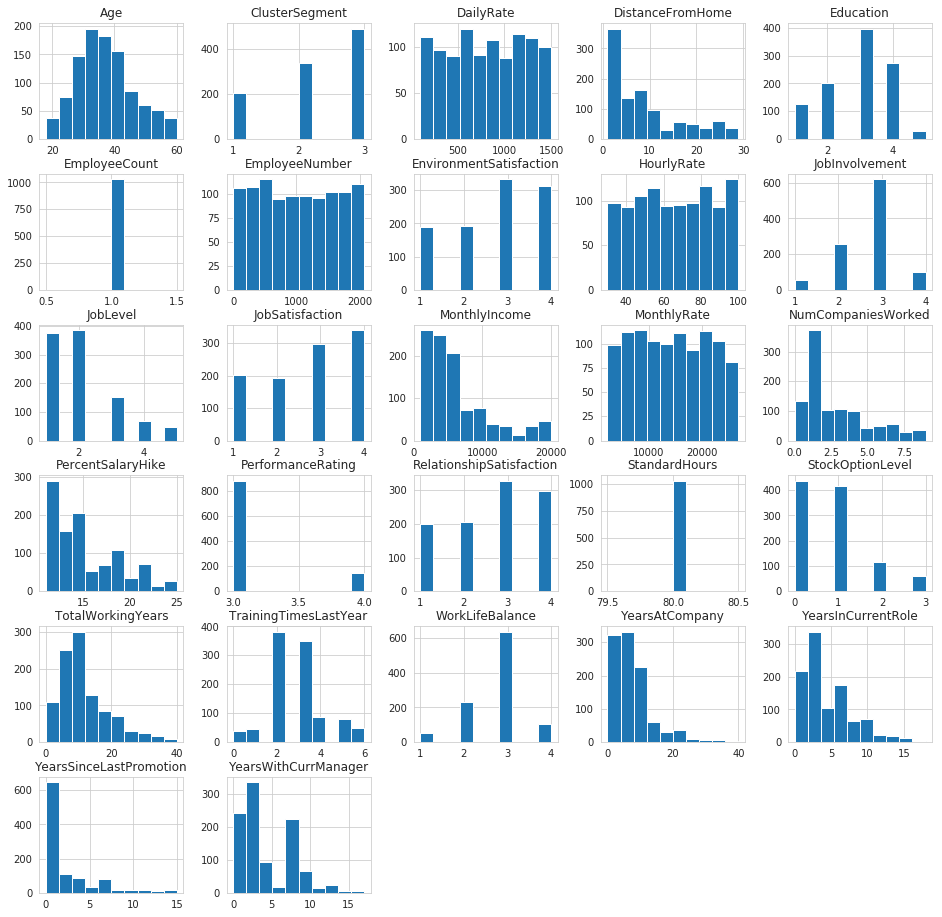

In [119]:
#Entire workforce - Plot distribution of all the continuous variables in the data set
df_full_data[df_full_data.dtypes[(df_full_data.dtypes=="float64")|(df_full_data.dtypes=="int64")].index.values].hist(figsize=[16,16]);

In [120]:
#summary statistics of entire workforce - count, mean, etc, min, 25%, 50%, 75% & max
statData = df_full_data.describe(include='all')
statData

,ClusterSegment,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1029.000000,1029.000000,1029,1029,1029.000000,1029,1029.000000,1029.000000,1029,1029.0,1029.000000,1029.000000,1029,1029.000000,1029.000000,1029.000000,1029,1029.000000,1029,1029.000000,1029.000000,1029.000000,1029,1029,1029.000000,1029.000000,1029.000000,1029.0,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000
unique,NaN,NaN,2,3,NaN,3,NaN,NaN,6,NaN,NaN,NaN,2,NaN,NaN,NaN,9,NaN,3,NaN,NaN,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,No,Travel_Rarely,NaN,Research & Development,NaN,NaN,Life Sciences,NaN,NaN,NaN,Male,NaN,NaN,NaN,Sales Executive,NaN,Married,NaN,NaN,NaN,Y,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,869,734,NaN,671,NaN,NaN,420,NaN,NaN,NaN,605,NaN,NaN,NaN,231,NaN,472,NaN,NaN,NaN,1029,733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.277940,36.979592,NaN,NaN,799.023324,NaN,8.967930,2.880466,NaN,1.0,1023.394558,2.749271,NaN,65.411079,2.738581,2.050534,NaN,2.753158,NaN,6415.706511,14244.068027,2.667638,NaN,NaN,15.101069,3.142857,2.701652,80.0,0.804665,11.183673,2.813411,2.770651,6.974733,4.252672,2.213800,4.068999
std,0.773157,9.116441,NaN,NaN,405.889808,NaN,8.005345,1.026069,NaN,0.0,607.169357,1.081014,NaN,20.440887,0.700666,1.087322,NaN,1.112933,NaN,4639.856113,7035.910047,2.473661,NaN,NaN,3.609258,0.350097,1.083753,0.0,0.857411,7.619367,1.295823,0.697322,6.008533,3.637021,3.211568,3.528387
min,1.000000,18.000000,NaN,NaN,103.000000,NaN,1.000000,1.000000,NaN,1.0,1.000000,1.000000,NaN,30.000000,1.000000,1.000000,NaN,1.000000,NaN,1009.000000,2104.000000,0.000000,NaN,NaN,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,30.000000,NaN,NaN,457.000000,NaN,2.000000,2.000000,NaN,1.0,479.000000,2.000000,NaN,48.000000,2.000000,1.000000,NaN,2.000000,NaN,2889.000000,8191.000000,1.000000,NaN,NaN,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,2.000000,36.000000,NaN,NaN,805.000000,NaN,7.000000,3.000000,NaN,1.0,1019.000000,3.000000,NaN,66.000000,3.000000,2.000000,NaN,3.000000,NaN,4877.000000,14168.000000,2.000000,NaN,NaN,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,3.000000,42.000000,NaN,NaN,1158.000000,NaN,13.000000,4.000000,NaN,1.0,1558.000000,4.000000,NaN,83.000000,3.000000,3.000000,NaN,4.000000,NaN,7991.000000,20364.000000,4.000000,NaN,NaN,17.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,10.000000,7.000000,3.000000,7.000000


In [121]:
#Check for nullvalues
df_full_data.isnull().any() #No null values

ClusterSegment              False
Age                         False
Attrition                   False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYe

In [122]:
#Count number of employees who left
df_full_data['Attrition'].value_counts()  #No=1233; Yes=237

No     869
Yes    160
Name: Attrition, dtype: int64

In [123]:
#Calculate attrition_rate
attrition_rate = df_full_data.Attrition.value_counts() / len(df_full_data)
attrition_rate

No     0.844509
Yes    0.155491
Name: Attrition, dtype: float64

In [124]:
#Mean comparison of all continuous variables between employees who left vs stayed 
meanData = df_full_data.groupby('Attrition').mean()
#df_full_data.groupby('Attrition').describe().unstack(1)  #Summary statistics comparing left vs stayed
meanData

,ClusterSegment,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Attrition,,,,,,,,,,,,,,,,,,,,,,,,,,,
No,2.322209,37.586881,814.004603,8.609896,2.903337,1.0,1027.58458,2.790564,65.482163,2.761795,2.127733,2.803222,6723.849252,14126.201381,2.644419,15.096663,3.143843,2.72267,80.0,0.837745,11.761795,2.867664,2.787112,7.345224,4.505178,2.285386,4.319908
Yes,2.037500,33.681250,717.656250,10.912500,2.756250,1.0,1000.63750,2.525000,65.025000,2.612500,1.631250,2.481250,4742.106250,14884.231250,2.793750,15.125000,3.137500,2.58750,80.0,0.625000,8.043750,2.518750,2.681250,4.962500,2.881250,1.825000,2.706250


In [0]:
#can export average_TFIDF_DF to csv and explore further if necessary
#meanData.to_csv('/Users/AgnesCheng/Desktop/498/Project/meandf_full_data.csv', encoding='utf-8', index=True)

In [126]:
df_full_data.Attrition.unique() #'Yes', 'No'

array(['Yes', 'No'], dtype=object)

In [127]:
df_full_data.BusinessTravel.unique() #'Travel_Rarely', 'Travel_Frequently', 'Non-Travel'

array(['Travel_Rarely', 'Travel_Frequently', 'Non-Travel'], dtype=object)

In [128]:
df_full_data.Department.unique() #'Sales', 'Research & Development', 'Human Resources'

array(['Human Resources', 'Research & Development', 'Sales'], dtype=object)

In [129]:
df_full_data.EducationField.unique() #'Life Sciences', 'Other', 'Medical', 'Marketing','Technical Degree', 'Human Resources'

array(['Technical Degree', 'Life Sciences', 'Marketing', 'Medical',
       'Other', 'Human Resources'], dtype=object)

In [130]:
df_full_data.Gender.unique() #'Female', 'Male'

array(['Male', 'Female'], dtype=object)

In [131]:
df_full_data.MaritalStatus.unique() #'Single', 'Married', 'Divorced'

array(['Single', 'Married', 'Divorced'], dtype=object)

In [132]:
df_full_data.Over18.unique() #'Y'

array(['Y'], dtype=object)

In [133]:
df_full_data.OverTime.unique() #'Yes', 'No'

array(['No', 'Yes'], dtype=object)

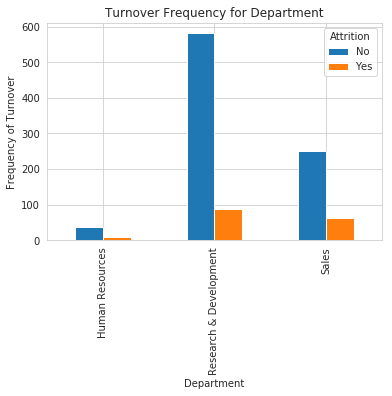

In [134]:
#Turnover by Department
pd.crosstab(df_full_data.Department,df_full_data.Attrition).plot(kind='bar')
plt.title('Turnover Frequency for Department')
plt.xlabel('Department')
plt.ylabel('Frequency of Turnover')
plt.savefig('department_bar_chart')

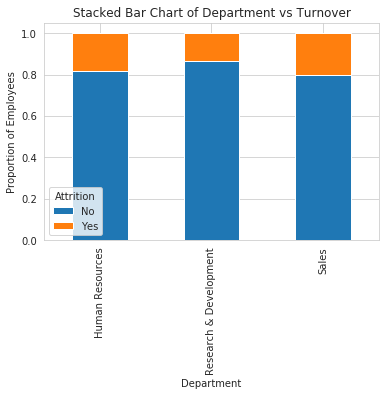

In [135]:
#Turnover Proportion by Department
table=pd.crosstab(df_full_data.Department, df_full_data.Attrition)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Department vs Turnover')
plt.xlabel('Department')
plt.ylabel('Proportion of Employees')
plt.savefig('department_chart')

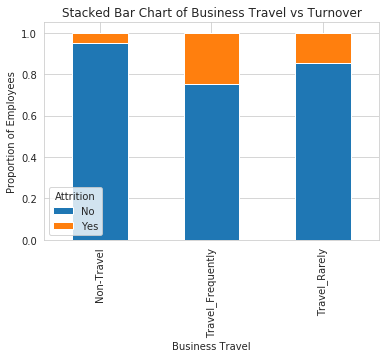

In [136]:
#Turnover Proportion by BusinessTravel
table=pd.crosstab(df_full_data.BusinessTravel, df_full_data.Attrition)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Business Travel vs Turnover')
plt.xlabel('Business Travel')
plt.ylabel('Proportion of Employees')
plt.savefig('business_travel_chart')

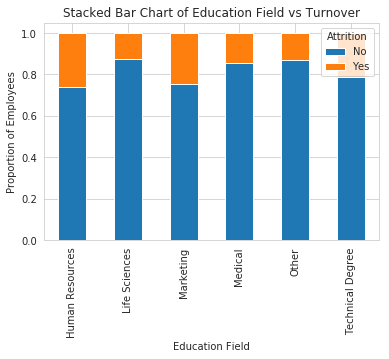

In [137]:
#Turnover Proportion by EducationField
table=pd.crosstab(df_full_data.EducationField, df_full_data.Attrition)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education Field vs Turnover')
plt.xlabel('Education Field')
plt.ylabel('Proportion of Employees')
plt.savefig('education_field_chart')

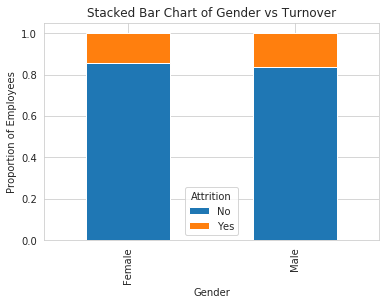

In [138]:
#Turnover Proportion by Gender
table=pd.crosstab(df_full_data.Gender, df_full_data.Attrition)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Gender vs Turnover')
plt.xlabel('Gender')
plt.ylabel('Proportion of Employees')
plt.savefig('gender_chart')

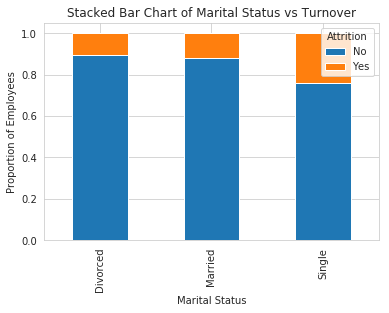

In [139]:
#Turnover Proportion by MaritalStatus
table=pd.crosstab(df_full_data.MaritalStatus, df_full_data.Attrition)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Turnover')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Employees')
plt.savefig('marital_status_chart')

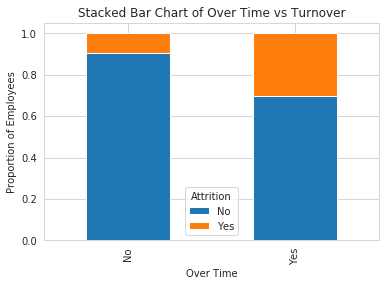

In [140]:
#Turnover Proportion by OverTime
table=pd.crosstab(df_full_data.OverTime, df_full_data.Attrition)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Over Time vs Turnover')
plt.xlabel('Over Time')
plt.ylabel('Proportion of Employees')
plt.savefig('over_time_chart')

In [141]:
###############################################################################
#Check for Outliers
###############################################################################

statdata2 = df_full_data.describe().transpose()

#Outliers are:
#Data point that falls outside of 1.5 times of an interquartile range above the 3rd quartile and below the 1st quartile
#iqr_df = df_full_data.quantile([.25,.75]).transpose()
#iqr = q3 - q1
#lower_bound = q1 -(1.5 * iqr) 
#upper_bound = q3 +(1.5 * iqr) 

statdata2.rename(columns={'25%': 'q1', '50%':'q2', '75%':'q3'}, inplace=True)

statdata2['lower_bound'] = statdata2.apply(lambda row: row.q1 -(1.5 * (row.q3 - row.q1)), axis=1)
statdata2['upper_bound'] = statdata2.apply(lambda row: row.q3 +(1.5 * (row.q3 - row.q1)), axis=1)

statdata2

,count,mean,std,min,q1,q2,q3,max,lower_bound,upper_bound
ClusterSegment,1029.0,2.277940,0.773157,1.0,2.0,2.0,3.0,3.0,0.5,4.5
Age,1029.0,36.979592,9.116441,18.0,30.0,36.0,42.0,60.0,12.0,60.0
DailyRate,1029.0,799.023324,405.889808,103.0,457.0,805.0,1158.0,1498.0,-594.5,2209.5
DistanceFromHome,1029.0,8.967930,8.005345,1.0,2.0,7.0,13.0,29.0,-14.5,29.5
Education,1029.0,2.880466,1.026069,1.0,2.0,3.0,4.0,5.0,-1.0,7.0
EmployeeCount,1029.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
EmployeeNumber,1029.0,1023.394558,607.169357,1.0,479.0,1019.0,1558.0,2064.0,-1139.5,3176.5
EnvironmentSatisfaction,1029.0,2.749271,1.081014,1.0,2.0,3.0,4.0,4.0,-1.0,7.0
HourlyRate,1029.0,65.411079,20.440887,30.0,48.0,66.0,83.0,100.0,-4.5,135.5
JobInvolvement,1029.0,2.738581,0.700666,1.0,2.0,3.0,3.0,4.0,0.5,4.5


In [142]:
#MonthlyIncome > 1.5 of the upperbound but it should not be considered an outlier since this is expected.
highInc = df_full_data[df_full_data.MonthlyIncome > 16581]
#There are 114 employees with Monthly income > 1.5*q3
highInc

,ClusterSegment,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
41,3,47,No,Travel_Rarely,202,Research & Development,2,2,Other,1,820,3,Female,33,3,4,Manager,4,Married,16752,12982,1,Y,Yes,11,3,3,80,1,26,3,2,26,14,3,0
60,2,39,No,Travel_Rarely,412,Research & Development,13,4,Medical,1,1307,3,Female,94,2,4,Manager,2,Divorced,17123,17334,6,Y,Yes,13,3,4,80,2,21,4,3,19,9,15,2
78,3,43,No,Travel_Rarely,782,Research & Development,6,4,Other,1,661,2,Male,50,2,4,Research Director,4,Divorced,16627,2671,4,Y,Yes,14,3,3,80,1,21,3,2,1,0,0,0
88,2,45,No,Travel_Rarely,1005,Research & Development,28,2,Technical Degree,1,1719,4,Female,48,2,4,Research Director,2,Single,16704,17119,1,Y,No,11,3,3,80,0,21,2,3,21,6,8,6
92,2,49,No,Travel_Rarely,1245,Research & Development,18,4,Life Sciences,1,638,4,Male,58,2,5,Research Director,3,Divorced,19502,2125,1,Y,Yes,17,3,3,80,1,31,5,3,31,9,0,9
93,3,48,No,Travel_Rarely,715,Research & Development,1,3,Life Sciences,1,1263,4,Male,76,2,5,Research Director,4,Single,18265,8733,6,Y,No,12,3,3,80,0,25,3,4,1,0,0,0
124,3,44,No,Travel_Rarely,1315,Research & Development,3,4,Other,1,671,4,Male,35,3,5,Manager,4,Married,19513,9358,4,Y,Yes,12,3,1,80,1,26,2,4,2,2,0,1
128,3,52,No,Travel_Rarely,699,Research & Development,1,4,Life Sciences,1,259,3,Male,65,2,5,Manager,3,Married,19999,5678,0,Y,No,14,3,1,80,1,34,5,3,33,18,11,9
139,3,42,No,Travel_Frequently,570,Research & Development,8,3,Life Sciences,1,809,2,Male,66,3,5,Manager,4,Divorced,18430,16225,1,Y,No,13,3,2,80,1,24,4,2,24,7,14,9
191,1,60,No,Travel_Rarely,422,Research & Development,7,3,Life Sciences,1,549,1,Female,41,3,5,Manager,1,Married,19566,3854,5,Y,No,11,3,4,80,0,33,5,1,29,8,11,10


In [143]:
###############################################################################
#Drop columns with the same values & encode categorical variables
###############################################################################

#Check columns to confirm if it contains the same value in all rows
df_full_data.EmployeeCount.unique() #1

array([1])

In [144]:
df_full_data.Over18.unique() #Y

array(['Y'], dtype=object)

In [145]:
df_full_data.StandardHours.unique() #80

array([80])

In [146]:
#Drop columns containing same values in all rows from dataframe using axis=1 (axis=0 drops rows)
data2 = df_full_data.drop(["EmployeeCount", "Over18", "StandardHours"], axis=1)
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 33 columns):
ClusterSegment              1029 non-null int64
Age                         1029 non-null int64
Attrition                   1029 non-null object
BusinessTravel              1029 non-null object
DailyRate                   1029 non-null int64
Department                  1029 non-null object
DistanceFromHome            1029 non-null int64
Education                   1029 non-null int64
EducationField              1029 non-null object
EmployeeNumber              1029 non-null int64
EnvironmentSatisfaction     1029 non-null int64
Gender                      1029 non-null object
HourlyRate                  1029 non-null int64
JobInvolvement              1029 non-null int64
JobLevel                    1029 non-null int64
JobRole                     1029 non-null object
JobSatisfaction             1029 non-null int64
MaritalStatus               1029 non-null object
MonthlyIncome         

In [147]:
#Initialize LabelEncoder() to encode a catagorical variables in data2 dataframe to int64
#Categorical variable to be encoded: Attrition, BusinessTravel, Department, EducationField, Gender, JpbRole, MaritalStatus, OverTime 
leData = data2.apply(LabelEncoder().fit_transform)
leData.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 33 columns):
ClusterSegment              1029 non-null int64
Age                         1029 non-null int64
Attrition                   1029 non-null int64
BusinessTravel              1029 non-null int64
DailyRate                   1029 non-null int64
Department                  1029 non-null int64
DistanceFromHome            1029 non-null int64
Education                   1029 non-null int64
EducationField              1029 non-null int64
EmployeeNumber              1029 non-null int64
EnvironmentSatisfaction     1029 non-null int64
Gender                      1029 non-null int64
HourlyRate                  1029 non-null int64
JobInvolvement              1029 non-null int64
JobLevel                    1029 non-null int64
JobRole                     1029 non-null int64
JobSatisfaction             1029 non-null int64
MaritalStatus               1029 non-null int64
MonthlyIncome               1

In [148]:
#Drop categorical variables from dataset to create the boxplots
df_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 36 columns):
ClusterSegment              1029 non-null int64
Age                         1029 non-null int64
Attrition                   1029 non-null object
BusinessTravel              1029 non-null object
DailyRate                   1029 non-null int64
Department                  1029 non-null object
DistanceFromHome            1029 non-null int64
Education                   1029 non-null int64
EducationField              1029 non-null object
EmployeeCount               1029 non-null int64
EmployeeNumber              1029 non-null int64
EnvironmentSatisfaction     1029 non-null int64
Gender                      1029 non-null object
HourlyRate                  1029 non-null int64
JobInvolvement              1029 non-null int64
JobLevel                    1029 non-null int64
JobRole                     1029 non-null object
JobSatisfaction             1029 non-null int64
MaritalStatus          

In [149]:
contData = leData.drop(["BusinessTravel", "Department", "EducationField", "Gender", "JobRole", "MaritalStatus", "OverTime", "PerformanceRating"], axis=1)
contData.head()

,ClusterSegment,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,2,1,1,199,1,1,302,0,22,1,0,3,162,672,1,1,2,0,1,3,3,1,0,0,0
1,2,19,0,300,18,2,807,2,55,2,1,2,572,980,3,6,0,3,9,2,1,4,3,0,2
2,2,14,0,387,3,2,425,2,68,1,1,2,604,689,1,1,2,1,14,3,2,14,13,6,8
3,2,23,0,353,3,0,897,2,51,2,2,2,798,979,0,2,3,1,23,3,3,22,14,13,5
4,2,24,0,162,11,3,962,1,47,2,1,3,493,21,3,1,2,2,14,4,2,0,0,0,0


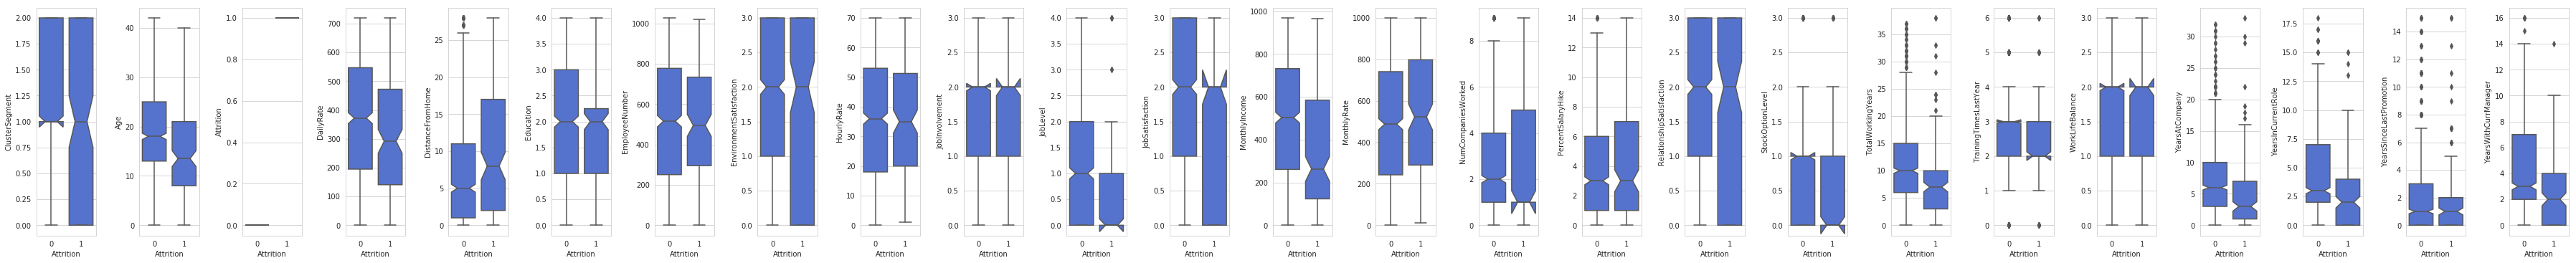

In [150]:
###############################################################################
# Boxplots of Continuous Variable by Attrition 0=No, 1=Yes
###############################################################################

l = contData.columns.values
numColumns=25
numRows = len(l)-1/numColumns
plt.figure(figsize=(numColumns*2,5*numRows))

for i in range(0,len(l)):
    plt.subplot(numRows + 1,numColumns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(x=contData.Attrition, y=contData[l[i]], color='royalblue',orient='v', notch=True)
    plt.tight_layout()
plt.savefig('BoxPlots_ContinuousVarByAttrition')


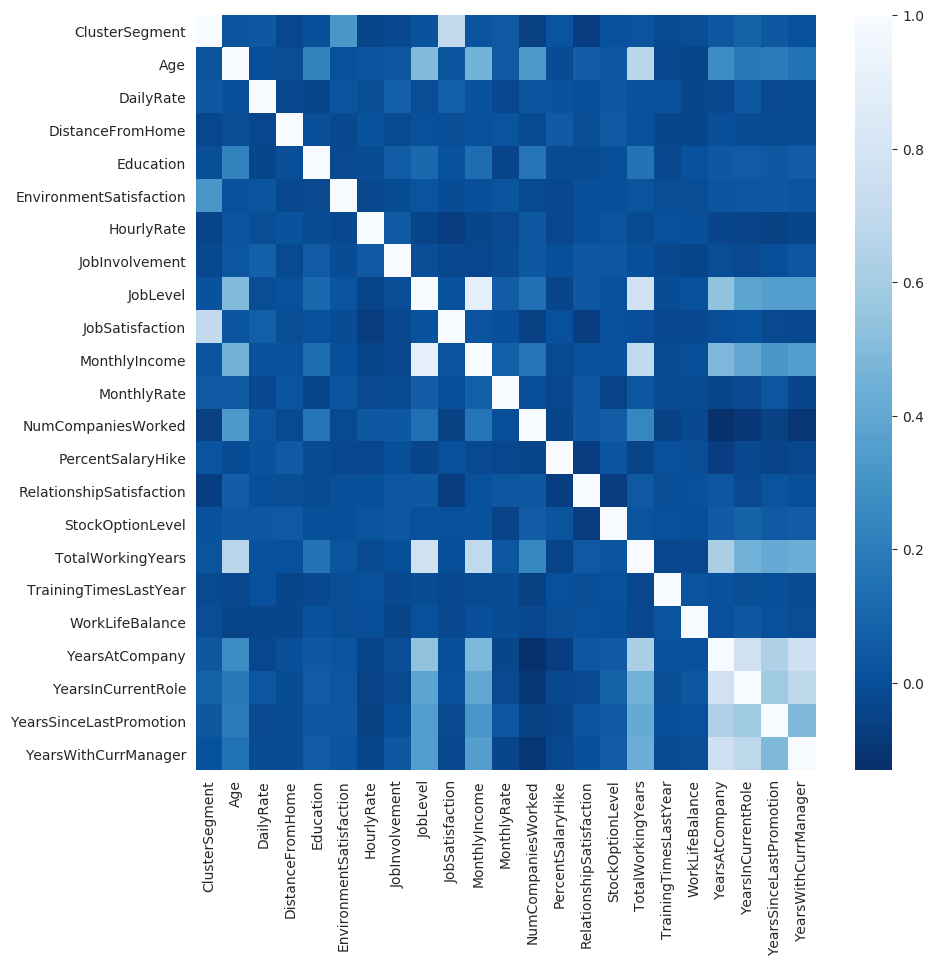

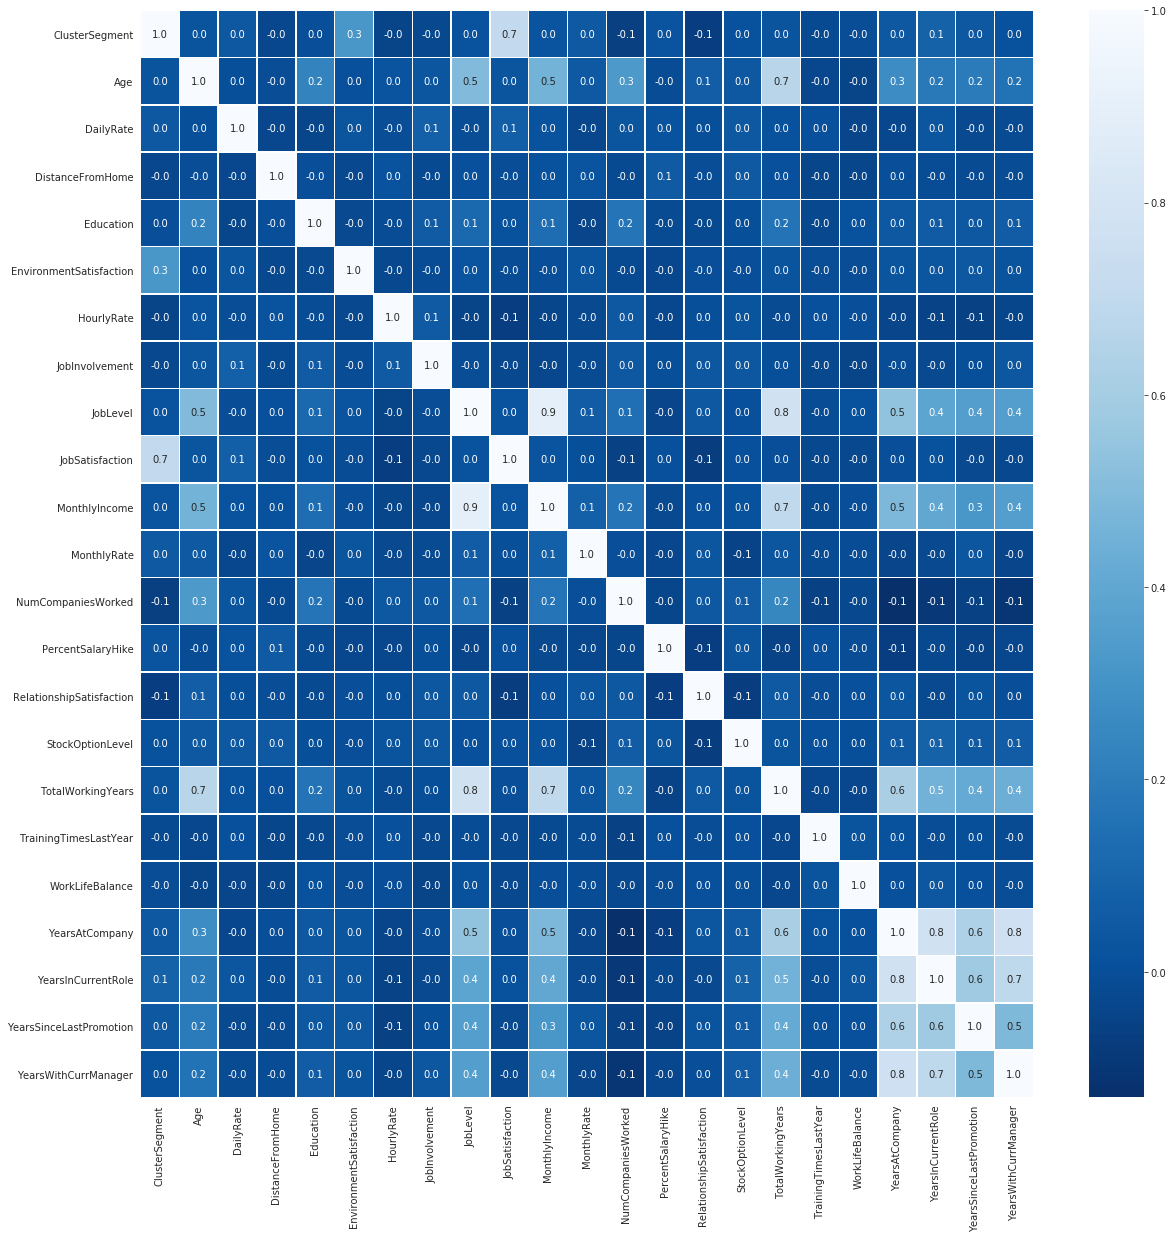

In [151]:
###############################################################################
#Correlation Analysis
###############################################################################

contData2 = contData.drop(["EmployeeNumber", "Attrition"], axis=1)


plt.figure(figsize= (10,10), dpi=100)
sns.heatmap(contData2.corr(),cmap='Blues_r') #cmap to  change color
#https://datascience.stackexchange.com/questions/10459/calculation-and-visualization-of-correlation-matrix-with-pandas
plt.savefig('corr_heatmap')

#Plot a correlation map for all numeric variables
f,ax = plt.subplots(figsize=(20, 20))
sns.heatmap(contData2.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap='Blues_r')

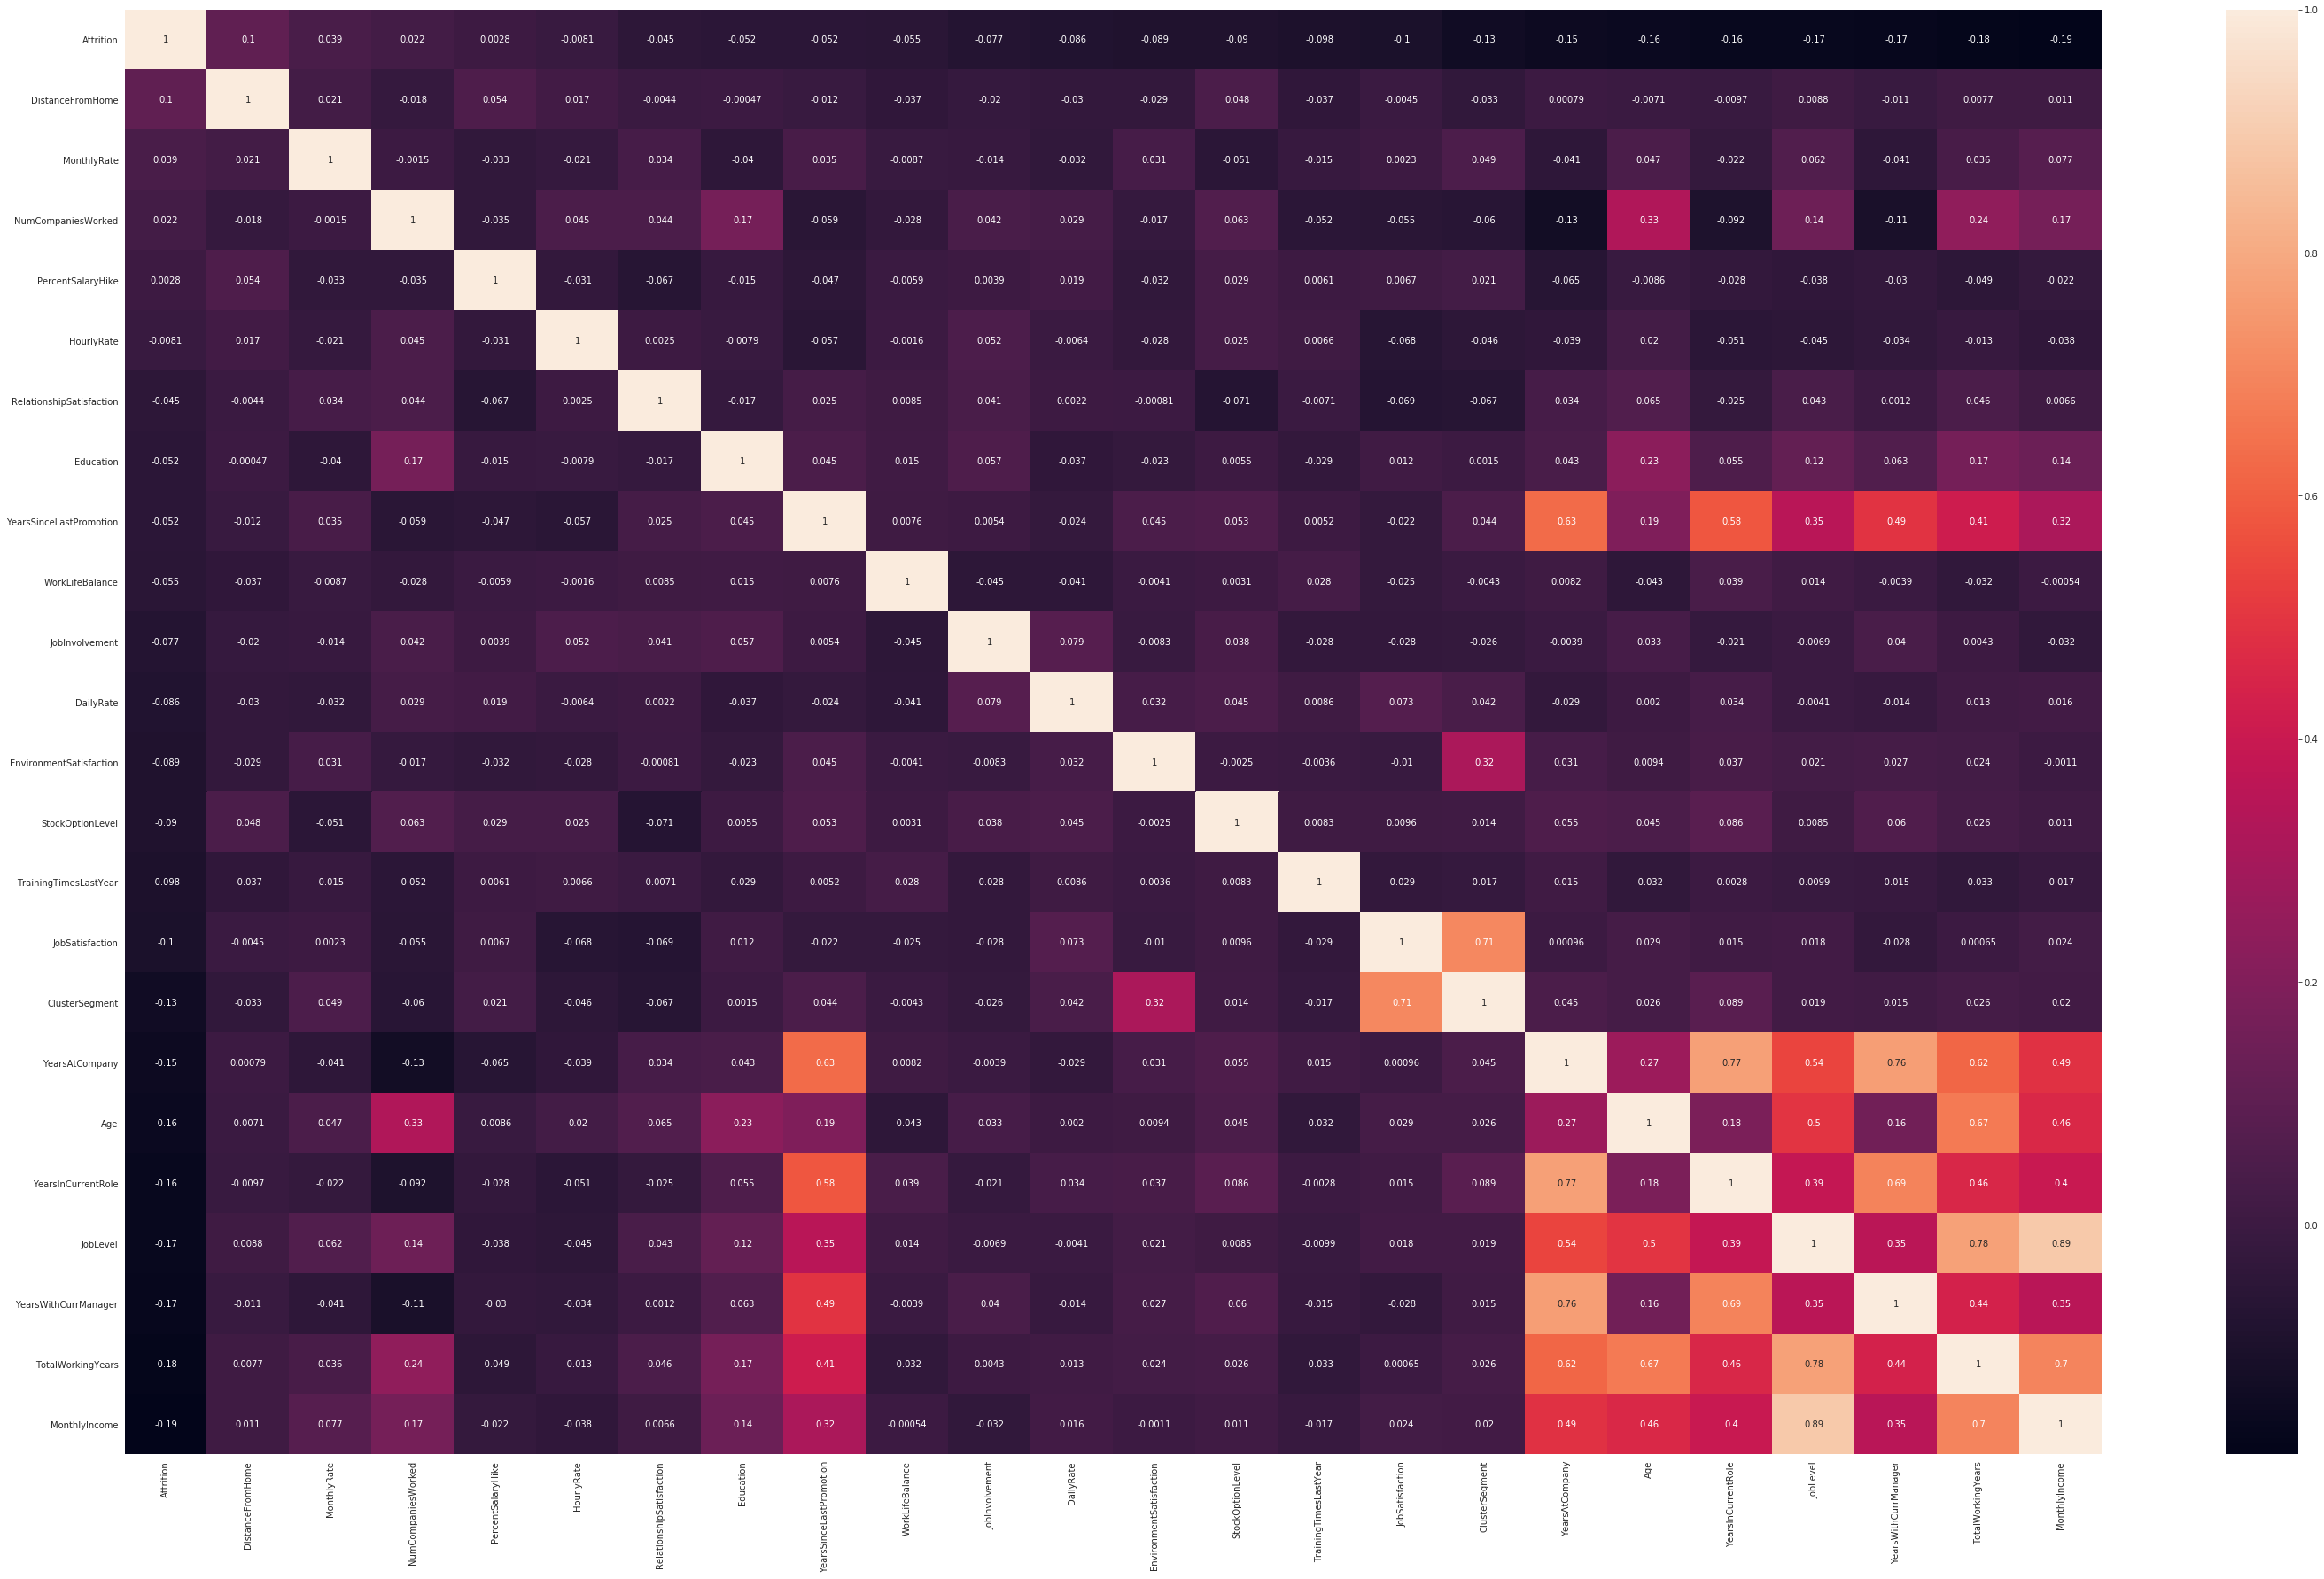

In [152]:
#https://nbviewer.jupyter.org/github/PBPatil/Exploratory_Data_Analysis-Wine_Quality_Dataset/blob/master/winequality_white.ipynb
#https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15
#https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
#attrition correlation matrix
contData3 = contData.drop(["EmployeeNumber"], axis=1)

k = 32 #number of variables for heatmap
cols = contData3.corr().nlargest(k, 'Attrition')['Attrition'].index
cm = contData3[cols].corr()
plt.figure(figsize=(50,30))
#sns.heatmap(cm, annot=True, cmap = 'Blues_r')
sns.heatmap(cm, annot=True)
plt.savefig('corr_heatmap_attrition')

In [153]:
#>>>>>>BusinessTravel has little correlation to Attrition .: 
#Since correlation is zero we can infer there is no linear relationship between these two predictors.However it is safe to drop these features in case you're applying Linear Regression model to the dataset.

#Correlation with output variable
cor = contData3.corr()
cor_target = abs(cor["Attrition"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features

ClusterSegment          0.133506
Age                     0.155321
Attrition               1.000000
DistanceFromHome        0.104281
JobLevel                0.165543
JobSatisfaction         0.104885
MonthlyIncome           0.188812
TotalWorkingYears       0.178436
YearsAtCompany          0.149945
YearsInCurrentRole      0.161878
YearsWithCurrManager    0.166023
Name: Attrition, dtype: float64

In [154]:
#Correlation with YearsAtCompany variable
cor = contData3.corr()
cor_target = abs(cor["YearsAtCompany"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

JobLevel                   0.538797
TotalWorkingYears          0.616238
YearsAtCompany             1.000000
YearsInCurrentRole         0.771269
YearsSinceLastPromotion    0.631572
YearsWithCurrManager       0.763944
Name: YearsAtCompany, dtype: float64

In [155]:
#Correlation with Age variable
cor = contData3.corr()
cor_target = abs(cor["Age"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

Age                  1.000000
TotalWorkingYears    0.668327
Name: Age, dtype: float64

In [156]:
#Correlation with MonthlyIncome variable
cor = contData3.corr()
cor_target = abs(cor["MonthlyIncome"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

JobLevel             0.890272
MonthlyIncome        1.000000
TotalWorkingYears    0.695720
Name: MonthlyIncome, dtype: float64

In [157]:
#Correlation with TotalWorkingYears variable
cor = contData3.corr()
cor_target = abs(cor["TotalWorkingYears"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

Age                  0.668327
JobLevel             0.775064
MonthlyIncome        0.695720
TotalWorkingYears    1.000000
YearsAtCompany       0.616238
Name: TotalWorkingYears, dtype: float64

#Feature Selection

In [158]:
df_full_data.columns

Index(['ClusterSegment', 'Age', 'Attrition', 'BusinessTravel', 'DailyRate',
       'Department', 'DistanceFromHome', 'Education', 'EducationField',
       'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate',
       'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

In [0]:
###############################################################################
#Feature Selection
###############################################################################
#Drop variables w/ high collinearity
drop_columns1 = ["EmployeeNumber", "BusinessTravel", "PercentSalaryHike", "YearsWithCurrManager", "YearsInCurrentRole", "JobLevel", "MonthlyIncome"]
df_full_data2 = df_full_data.drop(drop_columns1, axis=1)
#df_full_data = df_full_data.drop(["EmployeeNumber", "BusinessTravel", "PercentSalaryHike", "YearsWithCurrManager", "YearsInCurrentRole", "JobLevel", "MonthlyIncome"], axis=1)

#Drop columns containing same values in all rows from dataframe using axis=1 (axis=0 drops rows)
drop_columns2 = ["EmployeeCount", "Over18", "StandardHours"]
#df_full_data = df_full_data.drop(["EmployeeCount", "Over18", "StandardHours"], axis=1)
df_full_data2 = df_full_data2.drop(drop_columns2, axis=1)

In [160]:
df_full_data2.columns

Index(['ClusterSegment', 'Age', 'Attrition', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyRate',
       'NumCompaniesWorked', 'OverTime', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsSinceLastPromotion'],
      dtype='object')

In [161]:
#Initialize LabelEncoder() to encode a catagorical variables in df_full_data to int64
#Categorical variable to be encoded: Attrition, BusinessTravel, Department, EducationField, Gender, JpbRole, MaritalStatus, OverTime 
leData2 = df_full_data.apply(LabelEncoder().fit_transform)
leData2.info() 

response_var = 'Attrition'
X = leData2.drop('Attrition', axis=1)
y = leData2[response_var]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 36 columns):
ClusterSegment              1029 non-null int64
Age                         1029 non-null int64
Attrition                   1029 non-null int64
BusinessTravel              1029 non-null int64
DailyRate                   1029 non-null int64
Department                  1029 non-null int64
DistanceFromHome            1029 non-null int64
Education                   1029 non-null int64
EducationField              1029 non-null int64
EmployeeCount               1029 non-null int64
EmployeeNumber              1029 non-null int64
EnvironmentSatisfaction     1029 non-null int64
Gender                      1029 non-null int64
HourlyRate                  1029 non-null int64
JobInvolvement              1029 non-null int64
JobLevel                    1029 non-null int64
JobRole                     1029 non-null int64
JobSatisfaction             1029 non-null int64
MaritalStatus               1

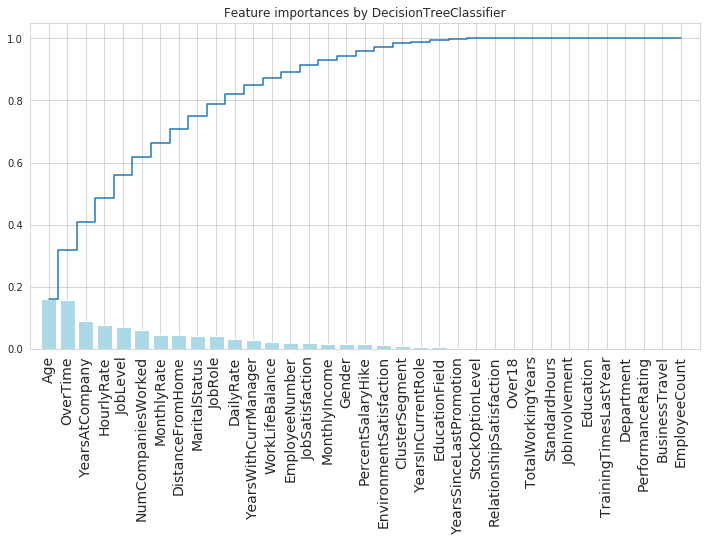

<Figure size 432x288 with 0 Axes>

In [162]:
#Split df into train and test
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=123, stratify=y)

#1) Feature Selection using DecisionTreeClassier()
#Source: https://www.kaggle.com/hjlee0421/predicting-employee-kernelover

dtree = tree.DecisionTreeClassifier(
    #max_depth=3,
    class_weight="balanced",
    min_weight_fraction_leaf=0.01
    )
dtree = dtree.fit(X,y)

## plot the importances ##
importances = dtree.feature_importances_
feat_names = leData2.drop(['Attrition'],axis=1).columns

indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()
plt.savefig('DecisionTreeFeaturesImportance')

In [163]:
#2) Feature Selection using Recursive Feature Elimination (RFE) 
model = LogisticRegression()

rfe = RFE(model, 15) #Number of Features Selected
rfe = rfe.fit(X,y)

print("Num Features: %s" % (rfe.n_features_))
print("Selected Features: %s" % (rfe.support_))
print("Feature Ranking: %s" % (rfe.ranking_))

sf = rfe.support_
fr = rfe.ranking_
featureNames = list(X.columns.values) 

#Create empty dataframe
RFE_df = pd.DataFrame()
#Add sf, fr and featureNames to the dataframe
RFE_df = pd.DataFrame(sf, fr)
RFE_df['featureNames'] = featureNames

#3)Feature Selection using Backward Elimination
#Adding constant column of ones, mandatory for sm.OLS model

X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
model.pvalues

Num Features: 15
Selected Features: [ True False False False  True False False False False False  True  True
 False  True  True False  True  True False False False False  True False
 False  True False False False  True  True False  True  True  True]
Feature Ranking: [ 1  9  6 16  1  8 11  7 21 18  1  1 15  1  1  5  1  1 12 17  2 20  1 10
 14  1 19 13  4  1  1  3  1  1  1]


const                       1.787917e-07
ClusterSegment              1.895159e-01
Age                         2.555872e-02
BusinessTravel              7.264922e-01
DailyRate                   7.858369e-02
Department                  1.932924e-03
DistanceFromHome            3.491129e-03
Education                   9.226866e-01
EducationField              6.262695e-01
EmployeeCount               4.237046e-03
EmployeeNumber              3.820878e-01
EnvironmentSatisfaction     7.347480e-03
Gender                      1.573578e-01
HourlyRate                  5.263572e-01
JobInvolvement              1.298056e-02
JobLevel                    7.108435e-02
JobRole                     1.826106e-01
JobSatisfaction             7.363290e-02
MaritalStatus               1.075313e-03
MonthlyIncome               1.181801e-04
MonthlyRate                 2.250424e-01
NumCompaniesWorked          3.547388e-03
Over18                      5.279450e-01
OverTime                    8.058108e-19
PercentSalaryHik

In [164]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['Age', 'Department', 'DistanceFromHome', 'EmployeeCount', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked', 'OverTime', 'RelationshipSatisfaction', 'TrainingTimesLastYear', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


Best alpha using built-in LassoCV: 0.019125
Best score using built-in LassoCV: 0.162110
ClusterSegment             -0.009316
Age                        -0.003717
BusinessTravel              0.000000
DailyRate                  -0.000125
Department                  0.000000
DistanceFromHome            0.004020
Education                  -0.000000
EducationField              0.000000
EmployeeCount               0.000000
EmployeeNumber             -0.000029
EnvironmentSatisfaction    -0.012571
Gender                      0.000000
HourlyRate                 -0.000255
JobInvolvement             -0.000000
JobLevel                    0.000000
JobRole                     0.002561
JobSatisfaction            -0.012724
MaritalStatus               0.023352
MonthlyIncome              -0.000168
MonthlyRate                 0.000046
NumCompaniesWorked          0.006775
Over18                      0.000000
OverTime                    0.107295
PercentSalaryHike          -0.000000
PerformanceRating       

Text(0.5, 1.0, 'Feature importance using Lasso Model')

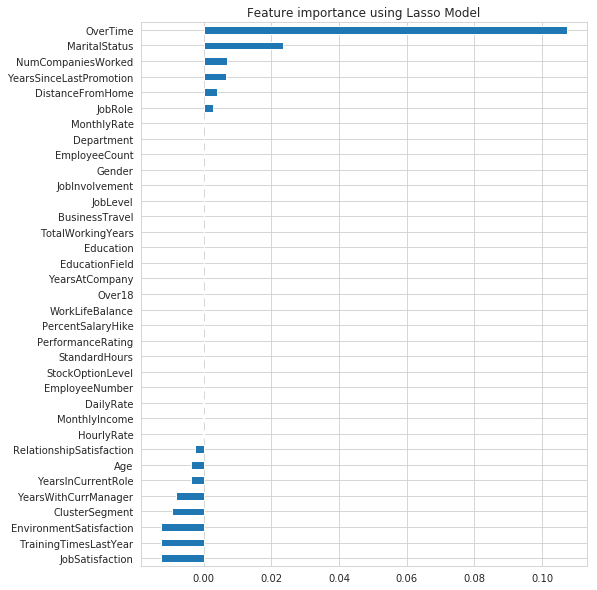

In [165]:
#4) Feature Selection using Embedded method
#Source: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)
print(coef)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")


In [166]:
#Source: https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
#5) Univariate Feature Selection
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features


                   Specs        Score
18         MonthlyIncome  6045.453864
3              DailyRate   909.589506
19           MonthlyRate   266.544355
28     TotalWorkingYears   169.332773
31        YearsAtCompany   114.190560
1                    Age   108.597553
5       DistanceFromHome    89.911909
34  YearsWithCurrManager    85.955975
32    YearsInCurrentRole    83.790770
22              OverTime    47.514444


# Prep Data for Modeling

In [0]:
# Drop columns irrelevant to our analysis
#drop_columns = ['BusinessTravel','Department','Education','EducationField','EmployeeCount','Gender','HourlyRate','JobLevel','JobRole','MonthlyIncome','MonthlyRate','Over18','PercentSalaryHike','StandardHours','StockOptionLevel','YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager']
# keep HourlyRate, MonthlyRate for bins
drop_columns = ['BusinessTravel','Department','Education','EducationField','EmployeeCount','Gender','JobLevel','JobRole','MonthlyIncome','Over18','PercentSalaryHike','StandardHours','StockOptionLevel','YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager']
df_holdout = df_holdout.drop(drop_columns, axis=1)
df_full_data = df_full_data.drop(drop_columns, axis=1)

In [0]:
df_holdout.set_index('EmployeeNumber',inplace=True)
df_full_data.set_index('EmployeeNumber',inplace=True)

Create new variables with bins

In [169]:
###############################################################################
#Data Binning
###############################################################################


# Age Custom binning #stacked bar on attrition
# Gen Z 18-24, Gen Y 25-33, Xennial 34-39, Gen X 40-54, Baby Boomers 55-75,  
#custombins = [18, 25, 40, 55, 75, 100]
#df_full_data['AgeRange'] = pd.cut(df_full_data['Age'], custombins, labels=['18_24', '25_39', '40_54', '55_75', 'Over75'])
#df_full_data['AgeRange'].value_counts(sort = False)
#df_holdout['AgeRange'] = pd.cut(df_holdout['Age'], custombins, labels=['18_24', '25_39', '40_54', '55_75', 'Over75'])
#df_holdout['AgeRange'].value_counts(sort = False)

# New bin tests
# retirement = ~67yrs old
# job hoppers usually 18-35
#custombins = [18, 36, 46, 56, 66, 100]
#df_full_data['AgeRange'] = pd.cut(df_full_data['Age'], custombins, labels=['18_35', '36_45', '46_55', '56_65', 'Over60'])
#df_full_data['AgeRange'].value_counts(sort = False)
#df_holdout['AgeRange'] = pd.cut(df_holdout['Age'], custombins, labels=['18_30', '31_40', '41_50', '51_60', 'Over60'])
#df_holdout['AgeRange'].value_counts(sort = False)


#DailyRate Binning 100-1500
# Equal width binning - 5 bins
#custombins = [100, 380, 660, 940, 1220, 1500]
#df_full_data['DailyRateRange'] = pd.cut(df_full_data['DailyRate'], custombins, labels=['100_379', '380_659', '660_939', '940_1219', '1220_1500'])
#df_full_data['DailyRateRange'].value_counts(sort = False)
#df_holdout['DailyRateRange'] = pd.cut(df_holdout['DailyRate'], custombins, labels=['100_379', '380_659', '660_939', '940_1219', '1220_1500'])
#df_holdout['DailyRateRange'].value_counts(sort = False)

#Distance Binning
custombins = [1, 5, 10, 20, 30, 1000]
df_full_data['DistanceFromHomeRange'] = pd.cut(df_full_data['DistanceFromHome'], custombins, labels=['1_4', '5_9', '10_19', '20_30', 'Over30'])
df_full_data['DistanceFromHomeRange'].value_counts(sort = False)
df_holdout['DistanceFromHomeRange'] = pd.cut(df_holdout['DistanceFromHome'], custombins, labels=['1_4', '5_9', '10_19', '20_30', 'Over30'])
df_holdout['DistanceFromHomeRange'].value_counts(sort = False)

#HourlyRate - Equal width binning - 5 bins
#custombins = [29, 44, 58, 72, 86, 100]
#df_full_data['HourlyRateRange'] = pd.cut(df_full_data['HourlyRate'], custombins, labels=['29_43', '44_57', '58_71', '72_85', '86_100'])
#df_full_data['HourlyRateRange'].value_counts(sort = False)
#df_holdout['HourlyRateRange'] = pd.cut(df_holdout['HourlyRate'], custombins, labels=['29_43', '44_57', '58_71', '72_85', '86_100'])
#df_holdout['HourlyRateRange'].value_counts(sort = False)

#MonthlyRate - Equal width binning - 5 bins
#custombins = [2000, 7000, 12000, 17000, 22000, 28000]
#df_full_data['MonthlyRateRange'] = pd.cut(df_full_data['MonthlyRate'], custombins, labels=['2000_6999', '7000_11999', '12000_16999', '17000_21999', '22000_28000'])
#df_full_data['MonthlyRateRange'].value_counts(sort = False)
#df_holdout['MonthlyRateRange'] = pd.cut(df_holdout['MonthlyRate'], custombins, labels=['2000_6999', '7000_11999', '12000_16999', '17000_21999', '22000_28000'])
#df_holdout['MonthlyRateRange'].value_counts(sort = False)

#TotalWorkingYears Binning - Equal width binning - 3 bins
#custombins = [0, 5, 10, 100]
#custombins = [0, 3, 6, 10, 100]
#df_full_data['TotalWorkingYearsRange'] = pd.cut(df_full_data['TotalWorkingYears'], custombins, labels=['NewGrads', 'EarlyCareer', 'Experienced', 'Senior'])
#df_full_data['TotalWorkingYearsRange'].value_counts(sort = False)
#df_holdout['TotalWorkingYearsRange'] = pd.cut(df_holdout['TotalWorkingYears'], custombins, labels=['NewGrads', 'EarlyCareer', 'Experienced', 'Senior'])
#df_holdout['TotalWorkingYearsRange'].value_counts(sort = False)


#NumCompaniesWorked Binning - Equal width binning - 4 bins
custombins = [0, 3, 6, 10, 100]
df_full_data['NumCompaniesWorkedRange'] = pd.cut(df_full_data['NumCompaniesWorked'], custombins, labels=['0_2', '3_5', '6_10', '10over'])
df_full_data['NumCompaniesWorkedRange'].value_counts(sort = False)
df_holdout['NumCompaniesWorkedRange'] = pd.cut(df_holdout['NumCompaniesWorked'], custombins, labels=['0_2', '3_5', '6_10', '10over'])
df_holdout['NumCompaniesWorkedRange'].value_counts(sort = False)


#YearsAtCompany Binning - Equal width binning - 4 bins
#custombins = [0, 5, 10, 20, 100]
#df_full_data['YearsAtCompanyRange'] = pd.cut(df_full_data['YearsAtCompany'], custombins, labels=['0_4', '5_9', '10_19', '20over'])
#df_full_data['YearsAtCompanyRange'].value_counts(sort = False)
#df_holdout['YearsAtCompanyRange'] = pd.cut(df_holdout['YearsAtCompany'], custombins, labels=['0_4', '5_9', '10_19', '20over'])
#df_holdout['YearsAtCompanyRange'].value_counts(sort = False)


#YearsAtCompany Binning - Equal width binning - 3 bins
custombins = [0, 3, 6, 10, 100]
df_full_data['YearsAtCompanyRange'] = pd.cut(df_full_data['YearsAtCompany'], custombins, labels=['0_2', '3_5', '6_10', '10over'])
df_full_data['YearsAtCompanyRange'].value_counts(sort = False)
df_holdout['YearsAtCompanyRange'] = pd.cut(df_holdout['YearsAtCompany'], custombins, labels=['0_2', '3_5', '6_10', '10over'])
df_holdout['YearsAtCompanyRange'].value_counts(sort = False)

0_2       137
3_5       115
6_10      108
10over     70
Name: YearsAtCompanyRange, dtype: int64

In [0]:
# Below I edit the code from the old data set to match the new variables:
# Convert Attrition to binary format for models
df_holdout['Attrition']=df_holdout['Attrition'].apply(lambda x : 1 if x=='Yes' else 0)
df_full_data['Attrition']=df_full_data['Attrition'].apply(lambda x : 1 if x=='Yes' else 0)

# Convert OverTime to binary format for models
df_holdout['OverTime']=df_holdout['OverTime'].apply(lambda x : 1 if x=='Yes' else 0)
df_full_data['OverTime']=df_full_data['OverTime'].apply(lambda x : 1 if x=='Yes' else 0)

In [0]:
# Convert all other categorical fields into numerical fields
# AKA the test set
df_holdout=pd.get_dummies(df_holdout)
# AKA the training set
df_full_data=pd.get_dummies(df_full_data)
#df_full=pd.get_dummies(df_full)

In [0]:
#temporarily remove columns for binning
# 
drop_columns = ['DistanceFromHome', 'YearsAtCompany']
df_holdout = df_holdout.drop(drop_columns, axis=1)
df_full_data = df_full_data.drop(drop_columns, axis=1)

In [173]:
# confirm formatting is correct
df_holdout.head(1)

,ClusterSegment,Age,Attrition,DailyRate,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyRate,NumCompaniesWorked,OverTime,PerformanceRating,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,DistanceFromHomeRange_1_4,DistanceFromHomeRange_5_9,DistanceFromHomeRange_10_19,DistanceFromHomeRange_20_30,DistanceFromHomeRange_Over30,NumCompaniesWorkedRange_0_2,NumCompaniesWorkedRange_3_5,NumCompaniesWorkedRange_6_10,NumCompaniesWorkedRange_10over,YearsAtCompanyRange_0_2,YearsAtCompanyRange_3_5,YearsAtCompanyRange_6_10,YearsAtCompanyRange_10over
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,49,0,279,3,61,2,2,24907,1,0,4,4,10,3,3,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0


In [174]:
# confirm formatting is correct
df_full_data.head(3)

,ClusterSegment,Age,Attrition,DailyRate,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyRate,NumCompaniesWorked,OverTime,PerformanceRating,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,DistanceFromHomeRange_1_4,DistanceFromHomeRange_5_9,DistanceFromHomeRange_10_19,DistanceFromHomeRange_20_30,DistanceFromHomeRange_Over30,NumCompaniesWorkedRange_0_2,NumCompaniesWorkedRange_3_5,NumCompaniesWorkedRange_6_10,NumCompaniesWorkedRange_10over,YearsAtCompanyRange_0_2,YearsAtCompanyRange_3_5,YearsAtCompanyRange_6_10,YearsAtCompanyRange_10over
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
566,3,19,1,489,1,52,2,4,18437,1,0,3,3,1,3,4,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0
1631,3,37,0,671,3,85,3,3,26493,3,0,3,1,9,2,2,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0
830,3,32,0,859,3,98,2,3,19124,1,0,3,3,14,3,3,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1


# Split and Normalize Data

In [0]:
# Separating the features(x) from the attrition values (y) for shared test/train set
#X_test = df_test.drop(['Attrition'], axis=1)
#y_test = df_test['Attrition'].as_matrix()
#X_train = df_train.drop(['Attrition'], axis=1)
#y_train = df_train['Attrition'].as_matrix()


# Separating the features(x) from the attrition values (y) for full data set (AKA train set)
X = df_full_data.drop(['Attrition'], axis=1)
y = df_full_data['Attrition'].as_matrix()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=24)

In [177]:
# Check amount of samples before SMOTE
print("Length of X training data is :",len(X_train))
print("Length of y training data is :",len(y_train))

Length of X training data is : 689
Length of y training data is : 689


In [0]:
#############################
#Comment out Smote because it did not benefit model
#############################

# Apply SMOTE
#smt = SMOTE(random_state=0)
#X_train, y_train = smt.fit_sample(X_train, y_train)
    
# Print SMOTE oversampling data
#smt_data_X = pd.DataFrame(data=X_train)
#smt_data_y= pd.DataFrame(data=y_train,columns=['y'])

# We can Check the numbers of our data
#print("Length of oversampled data is ",len(smt_data_X))
#print("Number of no subscription in oversampled data",len(smt_data_y[smt_data_y['y']==0]))
#print("Number of subscription",len(smt_data_y[smt_data_y['y']==1]))
#print("Proportion of no subscription data in oversampled data is ",len(smt_data_y[smt_data_y['y']==0])/len(smt_data_X))
#print("Proportion of subscription data in oversampled data is ",len(smt_data_y[smt_data_y['y']==1])/len(smt_data_X))

In [0]:
# Check amount of samples after SMOTE
#print("Length of X training data is :",len(X_train))
#print("Length of y training data is :",len(y_train))

In [0]:
# Normalize the training data
sc = StandardScaler()
# Fit the scaler to the training data
X_train = sc.fit_transform(X_train)
# Then standardise both training and test sets with that scaler
X_test = sc.transform (X_test)

# Create Definitions for Model Training

In [0]:
# Function to Train and Test Machine Learning Model
def train_test_ml_model(X_train, y_train, X_test, Model):
    model.fit(X_train, y_train) # Train the Model
    y_pred = model.predict(X_test) # Use the Model for prediction

    # Test the Model
    cm = confusion_matrix(y_test, y_pred)
    #predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, y_pred)

    # Plot/Display the results
    # First, the confusion matrix
    cm_plot(cm, Model)
    print('Accuracy of the Model', Model, str(accuracy) + '%')
    # Add a space for readability
    print(' ')
    # Second, the roc curve plot
    roc_plot(X_test, y_test, model)
    # Third, Log Loss result
    print(' ')
    print('Log Loss: ', log_loss(y_test, y_pred))
        # Add a space for readability
    print(' ')
    print(' ')
    print(classification_report(y_test, y_pred))

In [0]:
# Function to plot confusion matrix
def cm_plot(cm, Model):
    plt.clf()
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative', 'Positive']
    plt.title('Comparison of Prediction Result for ' + Model)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

In [0]:
#Function to plot ROC Curve

def roc_plot(X_test, y_test, model):
# calculate the fpr and tpr for all thresholds of the classification
  probs = model.predict_proba(X_test)
  preds = probs[:,1]
  fpr, tpr, threshold = roc_curve(y_test, preds)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(5,5))
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

In [0]:
# Function to display Cross-Validation Score

def cross_val(X, y, Model):
  # Adding space for readability between functions
  print(' ')
  print(' ')
  from sklearn.model_selection import cross_val_score
  #train model with cv of 10
  cv_scores = cross_val_score(model, X, y, cv=10)
  
  #Display the results
  print('List of Cross-Validation Scores:', cv_scores)
  print('Mean of Cross-Validation Scores:{}'.format(np.mean(cv_scores)))

# Model 1: XGBoost Classification
(Parallel Tree Gradient Boosting)

<Figure size 576x720 with 0 Axes>

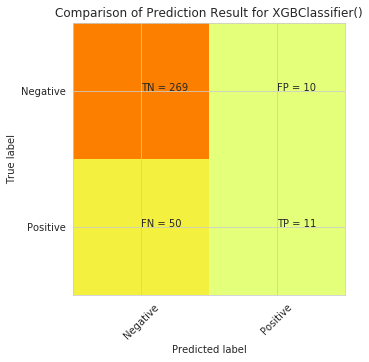

Accuracy of the Model XGBClassifier() 0.8235294117647058%
 


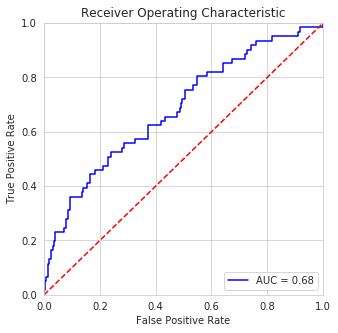

 
Log Loss:  6.095101704908656
 
 
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       279
           1       0.52      0.18      0.27        61

   micro avg       0.82      0.82      0.82       340
   macro avg       0.68      0.57      0.58       340
weighted avg       0.79      0.82      0.79       340

 
 
List of Cross-Validation Scores: [0.82524272 0.88349515 0.84466019 0.81553398 0.87378641 0.85436893
 0.86407767 0.84466019 0.83495146 0.84313725]
Mean of Cross-Validation Scores:0.8483913953931086


In [198]:
Model = "XGBClassifier()" # Adds to title in viz
model = XGBClassifier() # Create the Model

train_test_ml_model(X_train, y_train, X_test, Model)
cross_val(X, y, Model)

# Model 2: K-Nearest Neighbors Classification (KNN)

<Figure size 576x720 with 0 Axes>

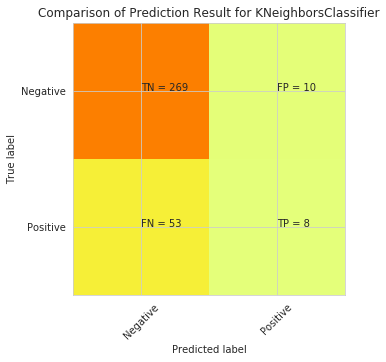

Accuracy of the Model KNeighborsClassifier 0.8147058823529412%
 


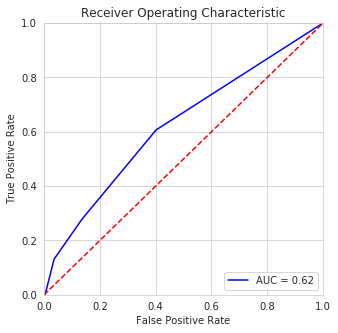

 
Log Loss:  6.399855614275515
 
 
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       279
           1       0.44      0.13      0.20        61

   micro avg       0.81      0.81      0.81       340
   macro avg       0.64      0.55      0.55       340
weighted avg       0.77      0.81      0.77       340

 
 
List of Cross-Validation Scores: [0.82524272 0.81553398 0.7961165  0.82524272 0.82524272 0.84466019
 0.80582524 0.82524272 0.85436893 0.8627451 ]
Mean of Cross-Validation Scores:0.8280220826194554


In [199]:
# Attempt 1: Out of Box

#n_neighbors=5 out of the box
Model = "KNeighborsClassifier"
model = KNeighborsClassifier()

train_test_ml_model(X_train,y_train,X_test,Model)
cross_val(X, y, Model)

<Figure size 576x720 with 0 Axes>

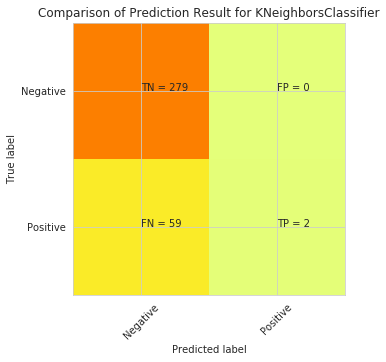

Accuracy of the Model KNeighborsClassifier 0.8264705882352941%
 


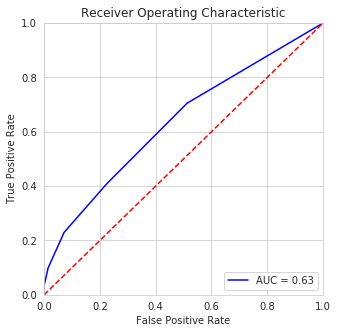

 
Log Loss:  5.99349355088156
 
 
              precision    recall  f1-score   support

           0       0.83      1.00      0.90       279
           1       1.00      0.03      0.06        61

   micro avg       0.83      0.83      0.83       340
   macro avg       0.91      0.52      0.48       340
weighted avg       0.86      0.83      0.75       340

 
 
List of Cross-Validation Scores: [0.83495146 0.84466019 0.84466019 0.83495146 0.83495146 0.84466019
 0.84466019 0.84466019 0.84466019 0.84313725]
Mean of Cross-Validation Scores:0.8415952788882544


In [200]:
# Attempt 2: Configuration

Model = "KNeighborsClassifier"
model = KNeighborsClassifier(n_neighbors=8)

train_test_ml_model(X_train,y_train,X_test,Model)
cross_val(X, y, Model)

# Model 3: Random Forest Classification

<Figure size 576x720 with 0 Axes>

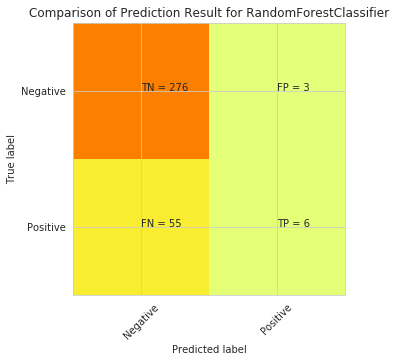

Accuracy of the Model RandomForestClassifier 0.8294117647058824%
 


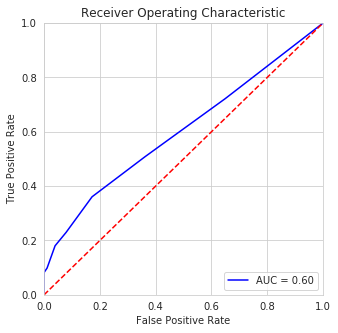

 
Log Loss:  5.891915969697384
 
 
              precision    recall  f1-score   support

           0       0.83      0.99      0.90       279
           1       0.67      0.10      0.17        61

   micro avg       0.83      0.83      0.83       340
   macro avg       0.75      0.54      0.54       340
weighted avg       0.80      0.83      0.77       340

 
 
List of Cross-Validation Scores: [0.85436893 0.88349515 0.84466019 0.81553398 0.85436893 0.86407767
 0.84466019 0.85436893 0.82524272 0.85294118]
Mean of Cross-Validation Scores:0.8493717875499713


In [201]:
# Attempt 1: Out of Box

# this uses default RF values
# Out of the box, RF will use Bootstrapping to resample data
Model = "RandomForestClassifier"
model = RandomForestClassifier()

train_test_ml_model(X_train,y_train,X_test,Model)
cross_val(X, y, Model)

<Figure size 576x720 with 0 Axes>

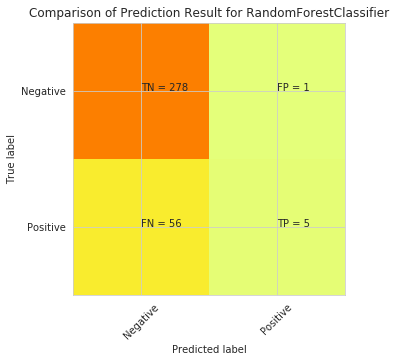

Accuracy of the Model RandomForestClassifier 0.8323529411764706%
 


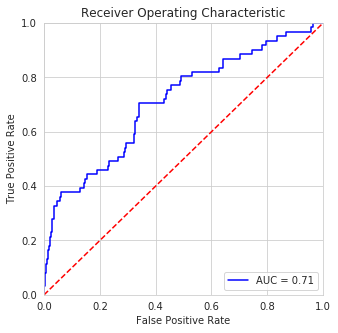

 
Log Loss:  5.790326629727469
 
 
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       279
           1       0.83      0.08      0.15        61

   micro avg       0.83      0.83      0.83       340
   macro avg       0.83      0.54      0.53       340
weighted avg       0.83      0.83      0.77       340

 
 
List of Cross-Validation Scores: [0.84466019 0.87378641 0.85436893 0.84466019 0.84466019 0.87378641
 0.85436893 0.84466019 0.85436893 0.84313725]
Mean of Cross-Validation Scores:0.8532457643251474


In [202]:
# Attempt 2: Configuration
# n_estimators = number of trees in the forest
# max_features = the maximum number of features Random Forest is allowed to try in individual tree
# min_samples_leaf = leaf is the end node of a decision tree, a smaller leaf makes the model more prone to capturing noise in train data 


#commenting this model out because it takes awhile to run
Model = "RandomForestClassifier"
model = RandomForestClassifier(n_estimators=5000, random_state=0, max_features=.1, max_depth=15)

train_test_ml_model(X_train,y_train,X_test,Model)
cross_val(X, y, Model)

# Method 4: SVM

<Figure size 576x720 with 0 Axes>

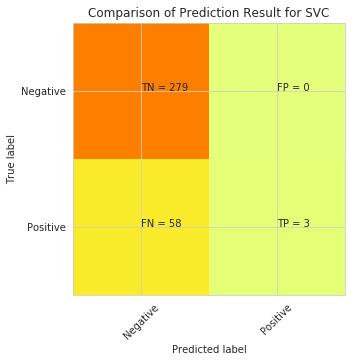

Accuracy of the Model SVC 0.8294117647058824%
 


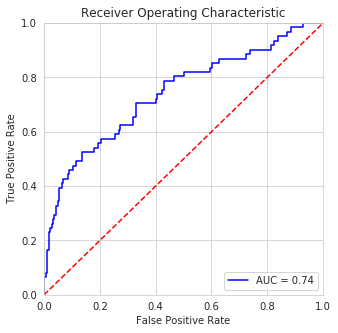

 
Log Loss:  5.891908914425941
 
 
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       279
           1       1.00      0.05      0.09        61

   micro avg       0.83      0.83      0.83       340
   macro avg       0.91      0.52      0.50       340
weighted avg       0.86      0.83      0.76       340

 
 
List of Cross-Validation Scores: [0.84466019 0.84466019 0.84466019 0.84466019 0.84466019 0.84466019
 0.84466019 0.84466019 0.84466019 0.84313725]
Mean of Cross-Validation Scores:0.8445079002474776


In [203]:
Model = "SVC"
model = SVC(probability=True) 
# Note, if we move forward with this model, we cannot use 'True'
# to product the ROC curve because the formatting remove the probability % and 
# results only in answers of 1 or 0.

train_test_ml_model(X_train,y_train,X_test,Model)
cross_val(X, y, Model)

# Method 4: LDA

<Figure size 576x720 with 0 Axes>

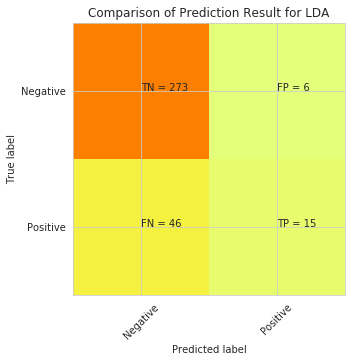

Accuracy of the Model LDA 0.8470588235294118%
 


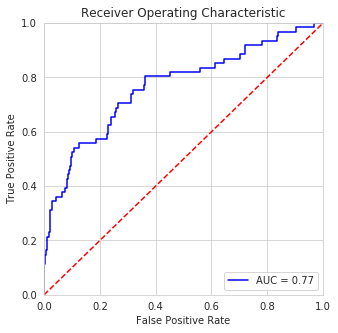

 
Log Loss:  5.282415206235108
 
 
              precision    recall  f1-score   support

           0       0.86      0.98      0.91       279
           1       0.71      0.25      0.37        61

   micro avg       0.85      0.85      0.85       340
   macro avg       0.79      0.61      0.64       340
weighted avg       0.83      0.85      0.81       340

 
 
List of Cross-Validation Scores: [0.85436893 0.89320388 0.86407767 0.81553398 0.90291262 0.88349515
 0.86407767 0.86407767 0.89320388 0.84313725]
Mean of Cross-Validation Scores:0.8678088711212641


In [204]:
Model = "LDA"
model = LinearDiscriminantAnalysis() 

train_test_ml_model(X_train,y_train,X_test,Model)
cross_val(X, y, Model)

# Method 5: Logisitic Regression

<Figure size 576x720 with 0 Axes>

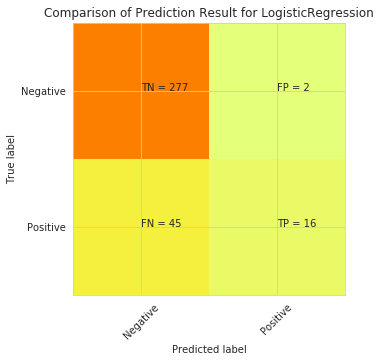

Accuracy of the Model LogisticRegression 0.861764705882353%
 


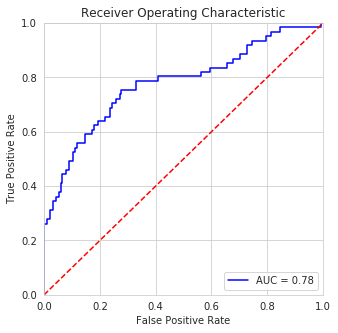

 
Log Loss:  4.774482616928419
 
 
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       279
           1       0.89      0.26      0.41        61

   micro avg       0.86      0.86      0.86       340
   macro avg       0.87      0.63      0.66       340
weighted avg       0.87      0.86      0.83       340

 
 
List of Cross-Validation Scores: [0.86407767 0.89320388 0.85436893 0.84466019 0.87378641 0.89320388
 0.88349515 0.86407767 0.88349515 0.87254902]
Mean of Cross-Validation Scores:0.8726917951646678


In [205]:
Model = "LogisticRegression"
model = LogisticRegression() 

train_test_ml_model(X_train,y_train,X_test,Model)
cross_val(X, y, Model)

In [0]:
# Transform holdout set to feed into model to get output
X_holdout = df_holdout.drop(['Attrition'], axis=1)
y_holdout = df_holdout['Attrition'].as_matrix()
# Apply transformation from earlier
X_holdout = sc.transform(X_holdout)

In [207]:
# Run the model on our full data so we can get the predictions in one dataset.
final = model.predict(X_holdout)
calc_prob = model.predict_proba(X_holdout)[:, 1]
Final_Output = df_holdout
Final_Output['Probability_of_Attrition'] = calc_prob
Final_Output['Final_Prediction'] = final
Final_Output.head()

,ClusterSegment,Age,Attrition,DailyRate,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyRate,NumCompaniesWorked,OverTime,PerformanceRating,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,DistanceFromHomeRange_1_4,DistanceFromHomeRange_5_9,DistanceFromHomeRange_10_19,DistanceFromHomeRange_20_30,DistanceFromHomeRange_Over30,NumCompaniesWorkedRange_0_2,NumCompaniesWorkedRange_3_5,NumCompaniesWorkedRange_6_10,NumCompaniesWorkedRange_10over,YearsAtCompanyRange_0_2,YearsAtCompanyRange_3_5,YearsAtCompanyRange_6_10,YearsAtCompanyRange_10over,Probability_of_Attrition,Final_Prediction
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,49,0,279,3,61,2,2,24907,1,0,4,4,10,3,3,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0.046588,0
7,1,27,0,591,1,40,3,2,16632,9,0,3,4,6,3,3,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0.174625,0
10,2,59,0,1324,3,81,4,1,9964,4,1,4,1,12,3,2,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0.137119,0
20,1,29,0,1389,2,51,4,1,10195,1,0,3,3,10,1,3,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0.068842,0
26,1,24,0,673,1,96,4,3,8232,0,0,3,4,5,5,2,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.042406,0


In [0]:
# Save Dataframe to CSV
Final_Output.to_csv("Final_Output.csv")

In [210]:
# Exploration of Log Reg Coefficients
# Reference used:
# https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

import statsmodels.api as sm
import statsmodels.formula.api as smf
logit_model=smf.Logit(y_train, X_train)
results=logit_model.fit(method='lbfgs')
print(results.summary2())

                            Results: Logit
Model:                 Logit              Pseudo R-squared:   -0.554   
Dependent Variable:    y                  AIC:                937.4102 
Date:                  2019-05-10 02:40   BIC:                1064.3969
No. Observations:      689                Log-Likelihood:     -440.71  
Df Model:              27                 LL-Null:            -283.59  
Df Residuals:          661                LLR p-value:        1.0000   
Converged:             1.0000             Scale:              1.0000   
No. Iterations:        25.0000                                         
-----------------------------------------------------------------------
       Coef.     Std.Err.      z    P>|z|      [0.025         0.975]   
-----------------------------------------------------------------------
x1     0.0099        0.1312  0.0757 0.9396        -0.2473        0.2672
x2    -0.0838        0.1157 -0.7245 0.4688        -0.3107        0.1430
x3    -0.1044        

In [211]:
# Column names for reference above
df_column_name = pd.DataFrame(list(df_full_data.drop(['Attrition'], axis=1).columns.values))
df_column_name.index = np.arange(1, len(df_column_name) + 1)
df_column_name

,0
1,ClusterSegment
2,Age
3,DailyRate
4,EnvironmentSatisfaction
5,HourlyRate
6,JobInvolvement
7,JobSatisfaction
8,MonthlyRate
9,NumCompaniesWorked
10,OverTime


In [219]:
# note: the new clustering dataset has slightly different columns
#model= smf.logit(formula="Attrition~ ClusterSegment	+ Age + DailyRate + EnvironmentSatisfaction + JobInvolvement + JobSatisfaction + NumCompaniesWorked + RelationshipSatisfaction + TotalWorkingYears + TrainingTimesLastYear + WorkLifeBalance + OverTime + PerformanceRating + MaritalStatus_Divorced + MaritalStatus_Married + MaritalStatus_Single + DistanceFromHomeRange_1_4 + DistanceFromHomeRange_5_9 + DistanceFromHomeRange_10_19 + DistanceFromHomeRange_20_30 + DistanceFromHomeRange_Over30 + NumCompaniesWorkedRange_0_2 + NumCompaniesWorkedRange_3_5 + NumCompaniesWorkedRange_6_10 + NumCompaniesWorkedRange_10over + YearsAtCompanyRange_0_2 + YearsAtCompanyRange_3_5 + YearsAtCompanyRange_6_10 + YearsAtCompanyRange_10over", data= df_full_data).fit(method='lbfgs')
model= smf.logit(formula="Attrition~ ClusterSegment	+ Age + DailyRate + EnvironmentSatisfaction + JobInvolvement + JobSatisfaction + NumCompaniesWorked + RelationshipSatisfaction + TotalWorkingYears + TrainingTimesLastYear + WorkLifeBalance + OverTime + PerformanceRating + MaritalStatus_Divorced + MaritalStatus_Married + MaritalStatus_Single", data= df_full_data).fit()
model.summary()

# GETTING THE ODDS RATIOS, Z-VALUE, AND 95% CI
model_odds = pd.DataFrame(np.exp(model.params), columns= ['OR'])
model_odds['z-value']= model.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(model.conf_int())
model_odds

Optimization terminated successfully.
         Current function value: 0.339355
         Iterations 8


,OR,z-value,2.5%,97.5%
Intercept,27.726031,9.999997e-01,0.000000,inf
ClusterSegment,0.826463,3.273815e-01,0.564380,1.210249
Age,0.980838,1.870798e-01,0.953047,1.009440
DailyRate,0.999577,8.426662e-02,0.999097,1.000057
EnvironmentSatisfaction,0.786465,1.995216e-02,0.642424,0.962800
JobInvolvement,0.704205,1.020926e-02,0.538876,0.920257
JobSatisfaction,0.760158,3.527158e-02,0.588878,0.981256
NumCompaniesWorked,1.113367,7.596346e-03,1.028955,1.204704
RelationshipSatisfaction,0.791600,9.974787e-03,0.662680,0.945599
TotalWorkingYears,0.917127,4.842587e-05,0.879642,0.956209


# Model 6: Neural Network

In [0]:
# Random seeds
np.random.seed(123)
rn.seed(123)
tf.set_random_seed(123)

# Convert Attrition to one-hot encoding for NN to be able to read
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
# Neural Network Architecture

# Create initial set of linear layers
model=Sequential()
# Now, add to our linear layers and note their neurons in each added layer
# Input dimension only needs to be noted for the first layer and it is the number of features/columns
model.add(Dense(input_dim=31, units=8, activation='relu', name='output_1'))
model.add(Dense(units=16, activation='relu', name='output_2'))
# Make sure output later has two neurons for each type of classification of attrition
model.add(Dense(units=2, activation='sigmoid'))

In [0]:
# Compile the Network
# More information on optimizer types:
# https://keras.io/optimizers/
model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])
# loss='binary_crossentropy' specifies that your model should optimize the log 
# loss for binary classification.  
# metrics=['accuracy'] specifies that accuracy should be printed out

In [229]:
# Review NN configuration
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
output_1 (Dense)             (None, 8)                 256       
_________________________________________________________________
output_2 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 434
Trainable params: 434
Non-trainable params: 0
_________________________________________________________________


In [230]:
History = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 689 samples, validate on 340 samples
Epoch 1/10
689/689 [==============================] - 1s 1ms/step - loss: 0.5878 - acc: 0.7112 - val_loss: 0.5103 - val_acc: 0.8206
Epoch 2/10
689/689 [==============================] - 0s 58us/step - loss: 0.3908 - acc: 0.8563 - val_loss: 0.4561 - val_acc: 0.8206
Epoch 3/10
689/689 [==============================] - 0s 54us/step - loss: 0.3512 - acc: 0.8563 - val_loss: 0.4585 - val_acc: 0.8206
Epoch 4/10
689/689 [==============================] - 0s 50us/step - loss: 0.3320 - acc: 0.8563 - val_loss: 0.4674 - val_acc: 0.8206
Epoch 5/10
689/689 [==============================] - 0s 52us/step - loss: 0.3185 - acc: 0.8563 - val_loss: 0.4686 - val_acc: 0.8206
Epoch 6/10
689/689 [==============================] - 0s 51us/step - loss: 0.3049 - acc: 0.8563 - val_loss: 0.4689 - val_acc: 0.8206
Epoch 7/10
689/689 [==============================] - 0s 53us/step - loss: 0.2929 - acc: 0.8570 - val_loss: 0

In [231]:
model.predict_classes(X_test)

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,

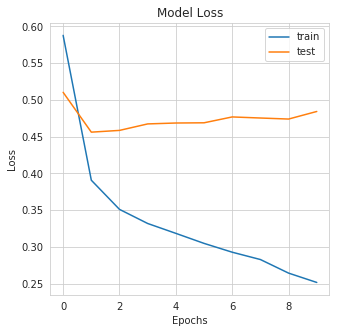

In [235]:
# Log Loss over time
plt.figure(figsize=(5,5))
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

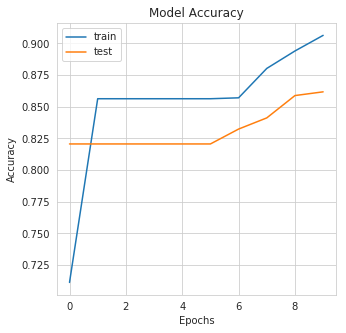

In [236]:
# Model accuracy over time
plt.figure(figsize=(5,5))
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [237]:
print(model.metrics_names)

['loss', 'acc']


In [238]:
model.evaluate(X_train,y_train)
# averaged loss and accuracy on train

689/689 [==============================] - 0s 30us/step


[0.22530397666815577, 0.9187227867338239]

In [239]:
model.evaluate(X_test,y_test)
# averaged loss and accuracy on text

340/340 [==============================] - 0s 53us/step


[0.48426939529531143, 0.8617647072848151]